In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import datetime
from scipy.signal import welch, windows

In [3]:
def read_binary_data(fname, value_label='B'):
    data_in = np.fromfile(fname, dtype=np.double)
    labview_epoch = datetime.datetime(year=1904, month=1, day=1, hour=0,minute=0, second=0) - datetime.timedelta(hours=1)
    unix_epoch = datetime.datetime.fromtimestamp(0)

    idx = data_in[0::3]
    time_epoch = data_in[1::3]
    data = data_in[2::3]

    time_UTC = []

    for t in time_epoch:
        time_UTC.append( datetime.datetime.fromtimestamp(t - (unix_epoch - labview_epoch).total_seconds()) )
    out = pd.DataFrame({'t': pd.to_datetime(time_UTC),
                        'idx': idx,
                        value_label: data})
    return out

In [3]:
data_folder = '../data/2020-06-29_B-field/'
f_names = os.listdir(data_folder)
data = {}
for f in f_names:
    key = f.split('_')[0][-2:]
    key += 's_b' if 'bottom' in f else 's' if 'shield' in f else ''
    df = read_binary_data(data_folder+f)
    df['B'] *= 100
    offset = float(f.split('_')[1][:3])
    print(offset)
    df['B'] += offset
    df['clock'] = df['t'].apply(lambda x: x.time())
    data[key] = df

-40.0
0.0
0.0


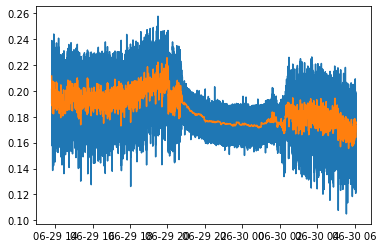

In [4]:
df = data['z+s_b']
plt.plot(df['t'], df['B'])
df_rs = df.resample(rule='30S', on='t').mean().reset_index()
plt.plot(df_rs['t'], df_rs['B'])

In [5]:
# huge measurement
data_folder = '../data/2020-06-18_B-field_weekend/'
f = 'meas_18_06_UTC1633z+_+50uT.txt'
s_t = pd.to_datetime('2020-06-18 ' + f.split('_')[3][:-2][-4:])
df_huge = pd.read_csv(data_folder + f, header=None, names=['B'])
offset = float(f.split('_')[-1][:3])
df_huge['B'] = df_huge['B'] * 100 + offset
df_huge['t'] = pd.date_range(start=s_t, periods=len(df_huge.index), freq='5ms')
df_huge['clock'] = df_huge['t'].apply(lambda x: x.time())

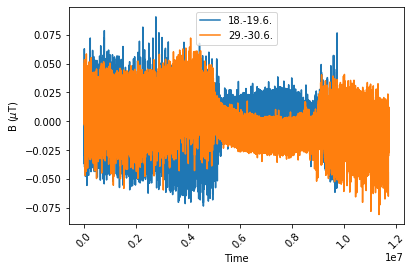

In [6]:
df_y = data['z+s_b']
time_lim = pd.datetime.combine(pd.to_datetime('2020-06-19'), df_y.iloc[-1]['clock'])
huge_trun = df_huge.loc[df_huge['t'] < time_lim]
huge_trun = huge_trun
huge_trun['B_0'] = huge_trun['B'] - np.mean(huge_trun['B']) 
plt.plot(huge_trun['B_0'], label='18.-19.6.')
df_y['B_0'] = df_y['B'] - np.mean(df_y['B'])
plt.plot(df_y['B_0'], label='29.-30.6.')
plt.ylabel(r'B ($\mu$T)')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.legend()

In [7]:
# load noise data
data_folder = '../data/2020-06-30_B-field/'
f_names = [x for x in os.listdir(data_folder) if 'noise' in x]
for f in f_names:
    key = ''.join(f.split('.')[0].split('_')[1:])
    df = read_binary_data(data_folder+f)
    df['B'] *= 100
    df['B_0'] = df['B'] - np.mean(df['B'])
    df['clock'] = df['t'].apply(lambda x: x.time())
    data[key] = df

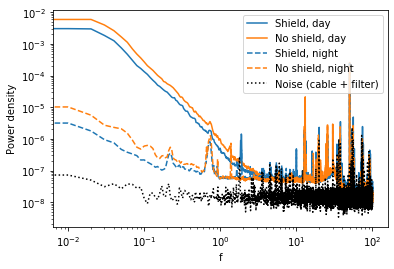

In [8]:
# power densities
shielded = df_y.loc[df_y['t'] < '2020-06-29 20:30']['B_0']
no_shield = huge_trun.loc[huge_trun['t'] < pd.to_datetime('2020-06-18 23:30')]['B_0']
shielded_night = df_y.loc[(df_y['t'] >= '2020-06-29 21:00')&(df_y['t'] <= pd.to_datetime('2020-06-30 01:30'))]['B_0']
no_shield_night = huge_trun.loc[(huge_trun['t'] >= pd.to_datetime('2020-06-19 00:00:01'))&(huge_trun['t'] <= pd.to_datetime('2020-06-19 04:30'))]['B_0']
f_s, P_s = welch(shielded, fs=200, window=windows.hann(20000))
f_n, P_n = welch(no_shield, fs=200, window=windows.hann(20000))
f_sn, P_sn = welch(shielded_night, fs=200, window=windows.hann(20000))
f_nn, P_nn = welch(no_shield_night, fs=200, window=windows.hann(20000))
f_noise, P_noise = welch(data['noise']['B_0'], fs=200, window=windows.hann(20000))
f_noisef, P_noisef = welch(data['noisefilter']['B_0'], fs=200, window=windows.hann(20000))
f_noisefc, P_noisefc = welch(data['noisefiltercable']['B_0'], fs=200, window=windows.hann(20000))
plt.loglog(f_s, P_s, color='C0', label='Shield, day')
plt.loglog(f_n, P_n, color='C1', label='No shield, day')
plt.loglog(f_sn, P_sn, linestyle='--', color='C0', label='Shield, night')
plt.loglog(f_nn, P_nn, linestyle='--', color='C1', label='No shield, night')
plt.loglog(f_noisefc, P_noisefc, linestyle=':', color='k', label='Noise (cable + filter)')
plt.legend(loc=1)
plt.xlabel('f')
plt.ylabel('Power density')
plt.savefig('../figs/power_density_day_night_noise.pdf', dpi=150)

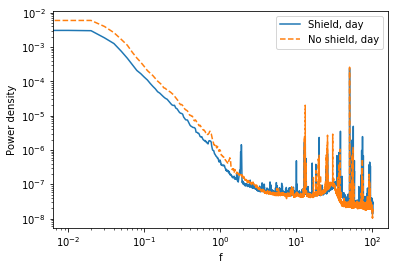

In [9]:
plt.loglog(f_s, P_s, color='C0', label='Shield, day')
plt.loglog(f_n, P_n, color='C1', linestyle='--', label='No shield, day')
plt.legend()
plt.xlabel('f')
plt.ylabel('Power density')
plt.savefig('../figs/power_density_day.pdf', dpi=150)

(array([737605.58333333, 737605.66666667, 737605.75      , 737605.83333333,
        737605.91666667, 737606.        , 737606.08333333, 737606.16666667,
        737606.25      ]),
 <a list of 9 Text xticklabel objects>)

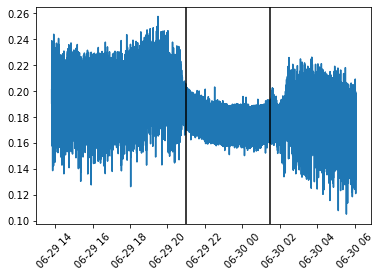

In [10]:
plt.plot(df_y['t'], df_y['B'])
plt.axvline(pd.to_datetime('2020-06-29 21:00'), color='k')
plt.axvline(pd.to_datetime('2020-06-30 01:30'), color='k')
plt.xticks(rotation=45)

(array([737594.66666667, 737594.75      , 737594.83333333, 737594.91666667,
        737595.        , 737595.08333333, 737595.16666667, 737595.25      ]),
 <a list of 8 Text xticklabel objects>)

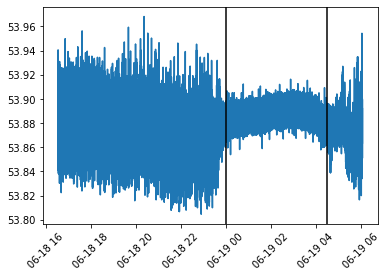

In [11]:
plt.plot(huge_trun['t'], huge_trun['B'])
plt.axvline(pd.to_datetime('2020-06-19 00:01'), color='k')
plt.axvline(pd.to_datetime('2020-06-19 04:30'), color='k')
plt.xticks(rotation=45)

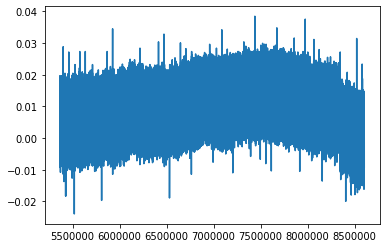

In [12]:
plt.plot(no_shield_night)

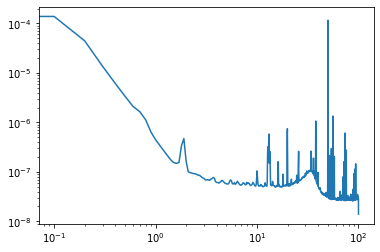

In [13]:
asd = welch(shielded, fs=200, window=windows.hann(2000))
plt.loglog(asd[0], asd[1])

In [14]:
np.savetxt('shield_day.txt', shielded)
np.savetxt('no_shield_day.txt', no_shield)
np.savetxt('shield_night.txt', shielded_night)
np.savetxt('no_shield_night.txt', no_shield_night)

In [4]:
# morning half-hour measurements
data_folder = '../data/2020-06-30_B-field/'
f_names = [x for x in os.listdir(data_folder) if 'z+' in x]
data30 = {}
for f in f_names:
    key = f.split('.')[0].split('_')[2:]
    key = '_'.join([x for x in key])
    if '1226' in f:
        key += 'long'
    df = read_binary_data(data_folder+f)
    df['B'] *= 10 if '10x' in f else 100
    offset = float(f.split('_')[1][:3])
    print(offset)
    df['B'] += offset
    df['B_0'] = df['B'] - np.mean(df['B'])
    df['clock'] = df['t'].apply(lambda x: x.time())
    data30[key] = df

0.0
0.0
0.0
-40.0
0.0


(1e-05, 0.1)

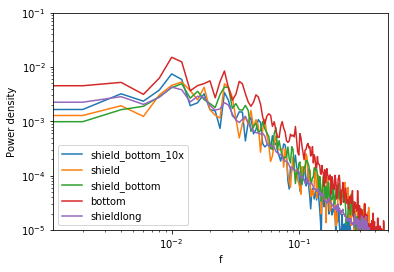

In [9]:
fig, ax = plt.subplots()
for k, v in data30.items():
    f, P = welch(v['B_0'], fs=200, window=windows.hann(100000))
    ax.loglog(f, P, label=k)
plt.legend()
plt.ylabel('Power density')
plt.xlabel('f')
plt.xlim([0, 0.5])
plt.ylim([1e-5, 1e-1])
#plt.savefig('../figs/power_density_30min.pdf', dpi=150)

In [1]:
f, P = welch(data30['shieldlong']['B_0'], fs=200, window=windows.hann(100000))
plt.loglog(f, P)
plt.legend()
plt.ylabel('Power density')
plt.xlabel('f')

NameError: name 'welch' is not defined

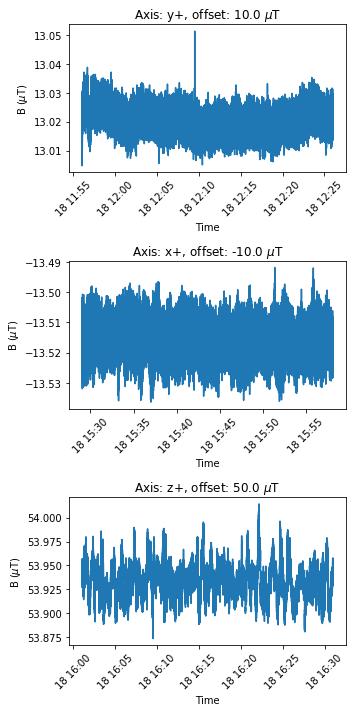

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
m30s = {k:v for k,v in data.items() if '30m' in k}
for (key, df), ax in zip(m30s.items(), axs):
    ax.plot(df['t'], df['B'])
    ax.set_ylabel(r"B ($\mu$T)")
    ax.set_xlabel("Time")
    ax.set_title(rf"Axis: {key[:2]}, offset: {df['offset'].iloc[0]} $\mu$T")
    ax.tick_params('x',labelrotation=45)
plt.tight_layout()
plt.savefig('../figs/B-field_30min.pdf', dpi=150)

0.14068603520000522


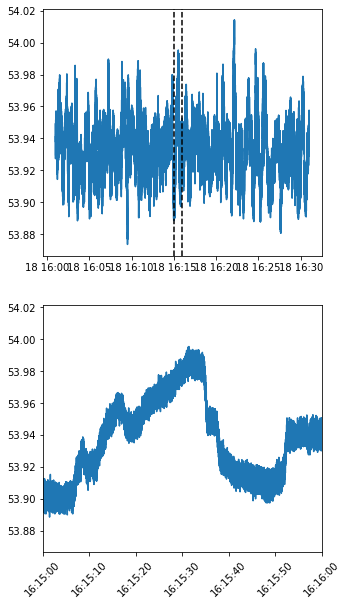

In [7]:
xlim_a = pd.to_datetime('2020-06-18 16:15:00.000')
xlim_b = pd.to_datetime('2020-06-18 16:16:00.000')
xlims = (xlim_a, xlim_b)
df = data['z+30m']
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,10))
axs[0].plot(df['t'], df['B'])
axs[0].axvline(xlim_a, linestyle='--', color='k')
axs[0].axvline(xlim_b, linestyle='--', color='k')
axs[1].plot(df['t'], df['B'])
axs[1].set_xlim(xlims)
axs[1].tick_params('x',labelrotation=45)
print(np.max(df['B']) - np.min(df['B']))

(array([-25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13,
        -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
          1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25]),
 array([0.59017158, 0.60656241, 0.62295471, 0.63934444, 0.65573971,
        0.67213347, 0.68852759, 0.70492999, 0.72132072, 0.73771333,
        0.75411366, 0.77050088, 0.78689742, 0.80329046, 0.81969023,
        0.83607441, 0.85246558, 0.86885735, 0.88524928, 0.90163798,
        0.91802909, 0.93442028, 0.9508097 , 0.96720909, 0.98359867,
        1.        , 0.98359867, 0.96720909, 0.9508097 , 0.93442028,
        0.91802909, 0.90163798, 0.88524928, 0.86885735, 0.85246558,
        0.83607441, 0.81969023, 0.80329046, 0.78689742, 0.77050088,
        0.75411366, 0.73771333, 0.72132072, 0.70492999, 0.68852759,
        0.67213347, 0.65573971, 0.63934444, 0.62295471, 0.60656241,
        0.59017158]),
 <matplot

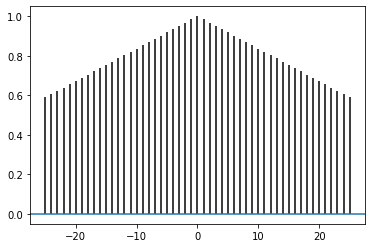

In [8]:
plt.acorr(df_rs['B'], maxlags=25)

In [9]:
df = data['y+30m']
(find_peaks(np.fft.fft(df['B'])[1:], height=100)[0] * 0.005) / 60

array([1.66666667e-04, 3.00218333e+01])

In [10]:
# huge measurement
data_folder = '../data/2020-06-18_B-field_weekend/'
f = 'meas_18_06_UTC1633z+_+50uT.txt'
s_t = pd.to_datetime('2020-06-18 ' + f.split('_')[3][:-2][-4:])
df_huge = pd.read_csv(data_folder + f, header=None, names=['B'])
offset = float(f.split('_')[-1][:3])
df_huge['B'] = df_huge['B'] * 100 + offset
df_huge['t'] = pd.date_range(start=s_t, periods=len(df_huge.index), freq='5ms')

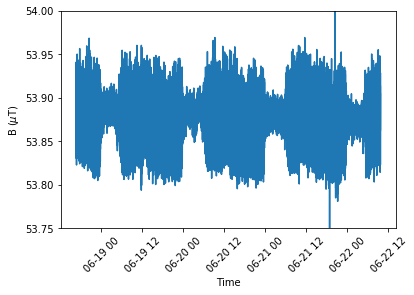

In [11]:
plt.plot(df_huge['t'], df_huge['B'])
plt.ylabel(r'B ($\mu$T)')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylim([53.75, 54.0])
plt.savefig("../figs/B-field_midsummer.pdf", dpi=150)

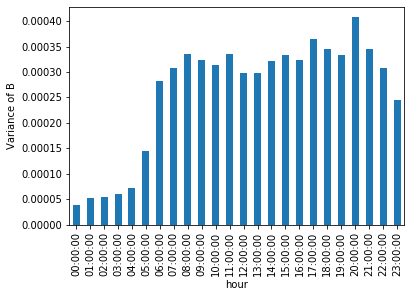

In [12]:
### hourly variance
df_huge['hour'] = df_huge['t'].dt.floor('H')
df_huge['hour'] = df_huge['hour'].dt.time
grouped = df_huge.groupby('hour')['B']
variances = grouped.var()
variances.plot.bar()
plt.ylabel(r'Variance of B')
plt.savefig("../figs/B-var_midsummer.pdf", dpi=150)

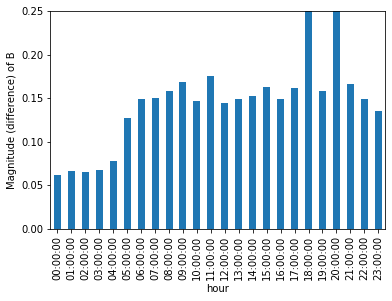

In [15]:
magnitude = grouped.max() - grouped.min()
magnitude.plot.bar()
plt.ylabel(r'Magnitude (difference) of B')
plt.ylim([0, .25])
plt.savefig("../figs/B-mag_midsummer.pdf", dpi=150)

In [11]:
np.max(df_huge['B']) - np.min(df_huge['B'])

1.207275390600003

In [29]:
data_folder = '../data/2020-06-23-B-field/'
f_names = os.listdir(data_folder)
for f in f_names:
    if not 'test' in f:
        key = f.split('_')[3][-2:] + ('flash' if 'flash' in f else 'long')
        s_t = pd.to_datetime(('2020-06-23 ' if '23' in f else '2020-06-24 ') + f.split('_')[3][:-2][-4:])
        df = pd.read_csv(data_folder + f, header=None, names=['B'])
        offset = float(f.split('_')[4][:3])
        df['B'] = df['B'] * 100 + offset
        df['offset'] = offset
        df['t'] = pd.date_range(start=s_t, periods=len(df.index), freq='5ms')
        data[key] = df

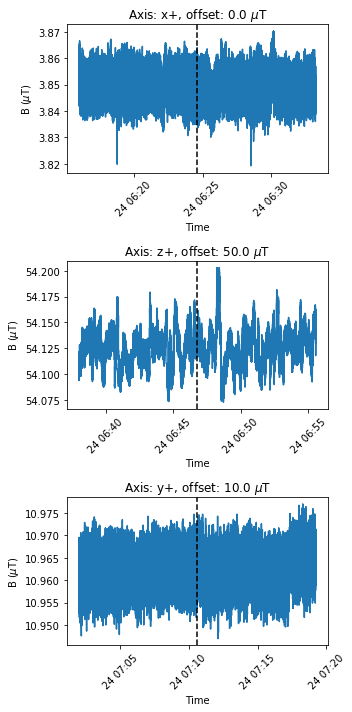

In [34]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
flashes = {k:v for k,v in data.items() if 'flash' in k}
for (key, df), ax in zip(flashes.items(), axs):
    ax.plot(df['t'], df['B'])
    ax.set_ylabel(r"B ($\mu$T)")
    ax.set_xlabel("Time")
    ax.set_title(rf"Axis: {key[:2]}, offset: {df['offset'].iloc[0]} $\mu$T")
    ax.tick_params('x',labelrotation=45)
    ax.axvline(df['t'].iloc[int(len(df.index)/2)], color='k', linestyle='--')
plt.tight_layout()
plt.savefig('../figs/B-field_flash.pdf', dpi=150)

In [31]:
data

{'y+30m':                 B  offset                       t
 0       13.017731    10.0 2020-06-18 11:56:00.000
 1       13.017883    10.0 2020-06-18 11:56:00.005
 2       13.015442    10.0 2020-06-18 11:56:00.010
 3       13.016968    10.0 2020-06-18 11:56:00.015
 4       13.015594    10.0 2020-06-18 11:56:00.020
 ...           ...     ...                     ...
 360261  13.023224    10.0 2020-06-18 12:26:01.305
 360262  13.022766    10.0 2020-06-18 12:26:01.310
 360263  13.022461    10.0 2020-06-18 12:26:01.315
 360264  13.022919    10.0 2020-06-18 12:26:01.320
 360265  13.020630    10.0 2020-06-18 12:26:01.325
 
 [360266 rows x 3 columns],
 'x+30m':                 B  offset                       t
 0      -13.518372   -10.0 2020-06-18 15:29:00.000
 1      -13.524475   -10.0 2020-06-18 15:29:00.005
 2      -13.516693   -10.0 2020-06-18 15:29:00.010
 3      -13.509827   -10.0 2020-06-18 15:29:00.015
 4      -13.517761   -10.0 2020-06-18 15:29:00.020
 ...           ...     ...        

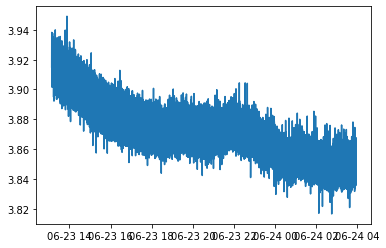

In [35]:
df = data['x+long']
plt.plot(df['t'], df['B'])